<img  style = "width:100%; height:80%;" src = "https://www.cloud-trade.com/hubfs/Imported_Blog_Media/Hero-Image-Template-2-Mar-10-2021-01-33-58-89-PM.jpg">
<img style="height:70px; width:70px; float:left;" src = "http://25.media.tumblr.com/2e07f1879192037cffcffc1f2ca0cf8c/tumblr_mld1zftHtz1qkjjfoo1_500.gif"><img style="height:70px; width:70px; float:right;" src = "http://25.media.tumblr.com/2e07f1879192037cffcffc1f2ca0cf8c/tumblr_mld1zftHtz1qkjjfoo1_500.gif"><h1 style = "background-color: black; color:white;text-align:center;"><b>Named</b><i> Entitiy </i><b>Recognition</b>

In [1]:
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('../input/ner-dataset/ner_datasetreference.csv', encoding= 'unicode_escape')
print(data.shape)
data.head()

(1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


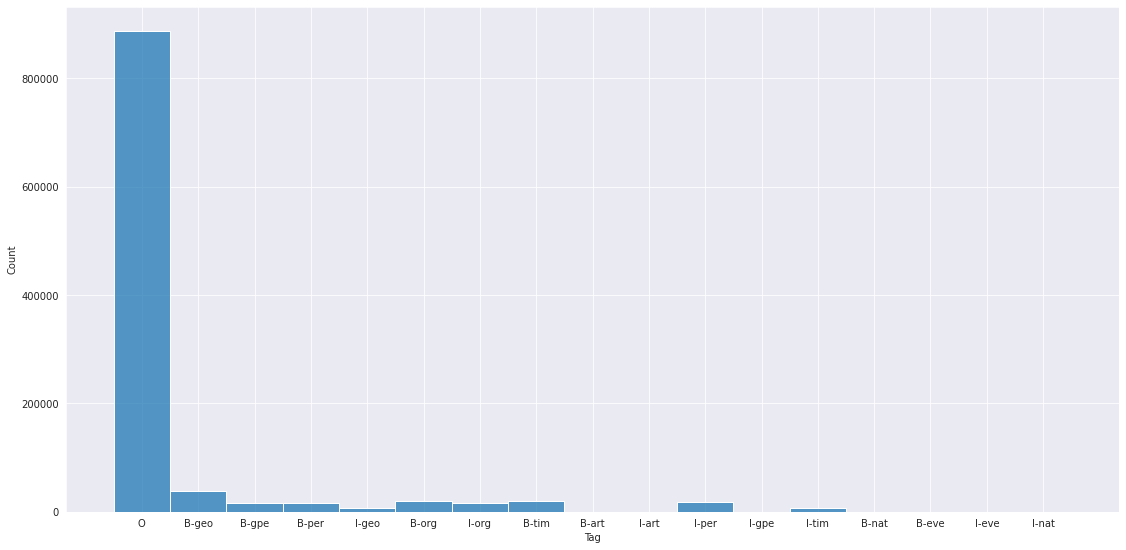

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(data['Tag'])
plt.tight_layout(pad=2)
plt.show()

<img style="height:70px; width:70px; float:left;" src = "https://i.pinimg.com/originals/e8/1d/8d/e81d8d8032101ffab2ddc3fd1e2d8ab1.gif"><img style="height:70px; width:70px; float:right;" src = "https://i.pinimg.com/originals/e8/1d/8d/e81d8d8032101ffab2ddc3fd1e2d8ab1.gif"><h2 style = "background-color: black; color:white;text-align:center;"><b><i>Data Preprocessing</i></b><h2>

In [3]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')
#Code language: Python (python)

In [4]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

In [5]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)
train_tags = np.array(train_tags)
val_tags = np.array(val_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'val_tags: ',val_tags.shape,'test_tags: ',test_tags.shape)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791
train_tags:  (32372, 104, 17) val_tags:  (10791, 104, 17) test_tags:  (4796, 104, 17)


In [6]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_temp_tags),
                                                 train_temp_tags)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

3366688
{0: 1456.1799307958477, 1: 1076.3069053708439, 2: 18.52750215999956, 3: 39.40319749069544, 4: 17.038670789661474, 5: 14.595067476471021, 6: 6188.764705882353, 7: 17.300643888200863, 8: 1571.749766573296, 9: 975.568820631701, 10: 0.06077954105731576, 11: 14.454453732445463, 12: 7.8159472171534965, 13: 17.381119061632024, 14: 45.111724507570685, 15: 956.717249218528, 16: 702.2711722987067}
(32372, 104)
(32372, 104)


<img style="height:70px; width:70px; float:left;" src = "https://64.media.tumblr.com/1a4eb159a9792663977408170e86a33a/tumblr_o1q075uyTb1uf5j8co1_500.gifv"><img style="height:70px; width:70px; float:right;" src = "https://64.media.tumblr.com/1a4eb159a9792663977408170e86a33a/tumblr_o1q075uyTb1uf5j8co1_500.gifv"><h2 style = "background-color: black; color:white;text-align:center;"><b><i>Model-Creation & Training</i></b><h2>

In [7]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [8]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [14]:
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add((Dense(n_tags, activation="softmax")))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [15]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 1456.1799307958477, 1: 1076.3069053708439, 2: 18.52750215999956, 3: 39.40319749069544, 4: 17.038670789661474, 5: 14.595067476471021, 6: 6188.764705882353, 7: 17.300643888200863, 8: 1571.749766573296, 9: 975.568820631701, 10: 28.52779541057316, 11: 14.454453732445463, 12: 7.8159472171534965, 13: 17.381119061632024, 14: 45.111724507570685, 15: 956.717249218528, 16: 702.2711722987067}
(32372, 104)


In [16]:
nlp_model = get_bilstm_lstm_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=5, validation_split=0.2, sample_weight = sample_weights) 
tf.keras.models.save_model(nlp_model, filepath  = "./nlp_model.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 104, 128)          66048     
_________________________________________________________________
lstm_5 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
dense_2 (Dense)              (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
405/405 [==============================] - 557s 1s/step - loss: 6.7007 - accuracy: 0.9654 - val_loss: 3.2634 - val_accuracy: 0.9681
Epoch 2/5
405/405 [==============================] - 546s 1s/step - loss: 3.0585 - accuracy: 0.9703 

#### **Model -  Evaluation**

In [17]:
nlp_model = tf.keras.models.load_model('./nlp_model.h5')

y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

(4796, 104) (4796, 104)
150/150 [==============================] - 12s 77ms/step - loss: 0.0643 - accuracy: 0.9814


[0.06426158547401428, 0.9814208149909973]

<img style="height:70px; width:70px; float:left;" src = "https://64.media.tumblr.com/037cef717d8faf83379d7b6a36c4ed3a/tumblr_ont3zyBF7r1uf5j8co1_400.gifv"><img style="height:70px; width:70px; float:right;" src = "https://64.media.tumblr.com/037cef717d8faf83379d7b6a36c4ed3a/tumblr_ont3zyBF7r1uf5j8co1_400.gifv"><h2 style = "background-color: black; color:white;text-align:center;"><b><i> Inference </i></b><h2>

In [21]:
def predict(seed):
    query  = test_tokens[seed]
    query_text = []
    for i in query.tolist():
        query_text.append(idx2token.get(i))
    print('Query_Text: ',' '.join(query_text[:10]))

    ans = y_test[seed]
    ans_text = []
    for i in ans.tolist():
        ans_text.append(idx2tag.get(i))
    print('Tag_Text: ',' '.join(ans_text[:10]))

    query = query.reshape(1,-1)
    pred = nlp_model.predict(query)
    pred = np.ravel(np.argmax(pred, axis=-1))
    print('Query: ',query.shape,'Prediction: ',pred.shape)

    pred_list = []
    for i in pred.tolist():
        pred_list.append(idx2tag.get(i))
    print('Prediction_Text: ',' '.join(pred_list[:10])) 
    print()
    print('--- Better-Representation---')
    print()
    rep_qr = []
    for q, r_tag in zip(query_text[:10], ans_text[:10]):
        rep_qr.append(q)
        rep_qr.append('['+r_tag+']')
    print('Actual_NER: ',' '.join(rep_qr),'....')
    print()
    rep_qp = []
    for q, r_tag in zip(query_text[:10], pred_list[:10]):
        rep_qp.append(q)
        rep_qp.append('['+r_tag+']')
    print('--'*70)
    print()
    print('Predicted_NER: ',' '.join(rep_qp),'....')

seed = 1
predict(seed)

Query_Text:  A spokesman says he expects the Tibetan leader to return
Tag_Text:  O O O O O O B-gpe O O O
Query:  (1, 104) Prediction:  (104,)
Prediction_Text:  O O O O O O B-gpe O O O

--- Better-Representation---

Actual_NER:  A [O] spokesman [O] says [O] he [O] expects [O] the [O] Tibetan [B-gpe] leader [O] to [O] return [O] ....

--------------------------------------------------------------------------------------------------------------------------------------------

Predicted_NER:  A [O] spokesman [O] says [O] he [O] expects [O] the [O] Tibetan [B-gpe] leader [O] to [O] return [O] ....


#### **SpaCy Implementation**

In [22]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('A spokesman says he expects the Tibetan leader to return')
displacy.render(text, style = 'ent', jupyter=True)